In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import shutil
from skimage.io import imread, imsave
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.ops import DeformConv2d
from pytorch_msssim import ssim
from torch_optimizer import Lookahead
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.transforms.functional import to_tensor, to_pil_image
from skimage.transform import swirl
from glob import glob
from torchvision.models import vgg16
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torch.nn import MSELoss

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating a synthetic dataset

For this project I want to create a dataset of images to train my model on, using a rnage of parameters for the swirl function. To swirl the images, i used the sklearn swirl function. I want each image to have its unswirled counterpart, so that we can test the accuracy of my model using my predefined accuracy metrics (PNSR and SSIM). To do this, I downloaded a subset of images from the Easy Portrait dataset on Kaggle, and wrote a function to create the swirled counterpart of the images, saving them in a directory called 'swirled'

In [2]:
#Making our file structure

base_dir = 'UDA_FinalProject_Broomhead/images'
train_dir = os.path.join(base_dir, 'train')
unswirled_dir = os.path.join(train_dir, 'unswirled')
swirled_dir = os.path.join(train_dir, 'swirled')

In [ ]:
#Directories for swirled and unswirled
os.makedirs(unswirled_dir, exist_ok=True)
os.makedirs(swirled_dir, exist_ok=True)

valid_extensions = ('.jpg', '.jpeg')

# Moving all image files in train directly into unswirled
for file_name in os.listdir(train_dir):
    src = os.path.join(train_dir, file_name)
    if os.path.isfile(src) and file_name.lower().endswith(valid_extensions):
        dst = os.path.join(unswirled_dir, file_name)
        shutil.move(src, dst)


In [ ]:
#Define ranges for stenght and radius- the swirl parameters
strength_range = np.arange(8, 15, 1)
radius_range = np.arange(300, 500, 1)

#Function to swirl and save images
def swirl_images(split='train'):
    unswirled_dir = f'images/{split}/unswirled'
    swirled_dir = f'images/{split}/swirled'
    os.makedirs(swirled_dir, exist_ok=True) #Creating swirled directory

    #All unswirled images
    for img_name in os.listdir(unswirled_dir):
        if img_name.lower().endswith(('jpg', 'jpeg')):
            img_path = os.path.join(unswirled_dir, img_name)
            image = imread(img_path)

            #Randomly selecting params from range
            strength = np.random.choice(strength_range)
            radius = np.random.choice(radius_range)

            #Swirling the image
            swirled_image = swirl(image, strength=strength, radius=radius, rotation=0)

            #Converting it back to uint8 to save
            swirled_image = (swirled_image * 255).astype(np.uint8) if swirled_image.max() <= 1 else swirled_image

            #Saving the swirled image
            swirled_path = os.path.join(swirled_dir, img_name)
            imsave(swirled_path, swirled_image)

# Create swirled images, keeping them all in train folder for now
swirl_images('train')

In [41]:
import os
import shutil

# Source and destination paths
source_train_dir = "UDA_FinalProject_Broomhead/images/train/"
dest_dir = "UDA_FinalProject_Broomhead/Final_Project/images/"

# Define subdirectories for swirled and unswirled
source_swirled_dir = os.path.join(source_train_dir, "swirled")
source_unswirled_dir = os.path.join(source_train_dir, "unswirled")
dest_swirled_dir = os.path.join(dest_dir, "swirled")
dest_unswirled_dir = os.path.join(dest_dir, "unswirled")

# Ensure destination directories exist
os.makedirs(dest_swirled_dir, exist_ok=True)
os.makedirs(dest_unswirled_dir, exist_ok=True)

# Get the list of matching images
valid_extensions = ('.jpg', '.jpeg')
swirled_images = sorted([f for f in os.listdir(source_swirled_dir) if f.lower().endswith(valid_extensions)])
unswirled_images = sorted([f for f in os.listdir(source_unswirled_dir) if f.lower().endswith(valid_extensions)])

# Ensure matching pairs exist
matching_pairs = list(set(swirled_images) & set(unswirled_images))
if len(matching_pairs) < 1000:
    raise ValueError(f"Not enough matching pairs in train directory. Found {len(matching_pairs)}, required 1000.")

# Move the first 1000 pairs
for img in matching_pairs[:1000]:
    # Move swirled images
    shutil.move(os.path.join(source_swirled_dir, img), os.path.join(dest_swirled_dir, img))
    # Move unswirled images
    shutil.move(os.path.join(source_unswirled_dir, img), os.path.join(dest_unswirled_dir, img))

print(f"Moved 1000 image pairs from train to {dest_dir}.")


Moved 1000 image pairs from train to UDA_FinalProject_Broomhead/Final_Project/images/.


In [42]:
#Making directories
base_dir = 'UDA_FinalProject_Broomhead/Final_Project/images'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [44]:
#Subdirectories 
swirled_dir = os.path.join(train_dir, "swirled")
unswirled_dir = os.path.join(train_dir, "unswirled")

#Create train/test/val datasets
def create_datasets():
    for folder in [train_dir, test_dir, val_dir]:
        os.makedirs(os.path.join(folder, "swirled"), exist_ok=True)
        os.makedirs(os.path.join(folder, "unswirled"), exist_ok=True)

    swirled_images = set(os.listdir(swirled_dir))
    unswirled_images = set(os.listdir(unswirled_dir))
    matching_pairs = list(swirled_images & unswirled_images)

    #Matching pairs in order
    matching_pairs.sort()

    total_required = 1000  #change as needed
    if len(matching_pairs) < total_required:
        raise ValueError(f"Not enough matching image pairs. Found: {len(matching_pairs)}, Required: {total_required}")

    #Train/test/val split
    train_pairs = matching_pairs[:800]
    test_pairs = matching_pairs[800:900]
    val_pairs = matching_pairs[900:1000]

    #Move pairs of images
    def move_pairs(pairs, target_dir):
        for img in pairs:
            shutil.move(os.path.join(swirled_dir, img), os.path.join(target_dir, "swirled", img))
            shutil.move(os.path.join(unswirled_dir, img), os.path.join(target_dir, "unswirled", img))

    #Moving for each dir
    move_pairs(train_pairs, train_dir)
    move_pairs(test_pairs, test_dir)
    move_pairs(val_pairs, val_dir)

    print("Datasets created successfully!")
    print(f"Train: {len(train_pairs)} pairs, Test: {len(test_pairs)} pairs, Val: {len(val_pairs)} pairs")

create_datasets()


Datasets created successfully!
Train: 800 pairs, Test: 100 pairs, Val: 100 pairs


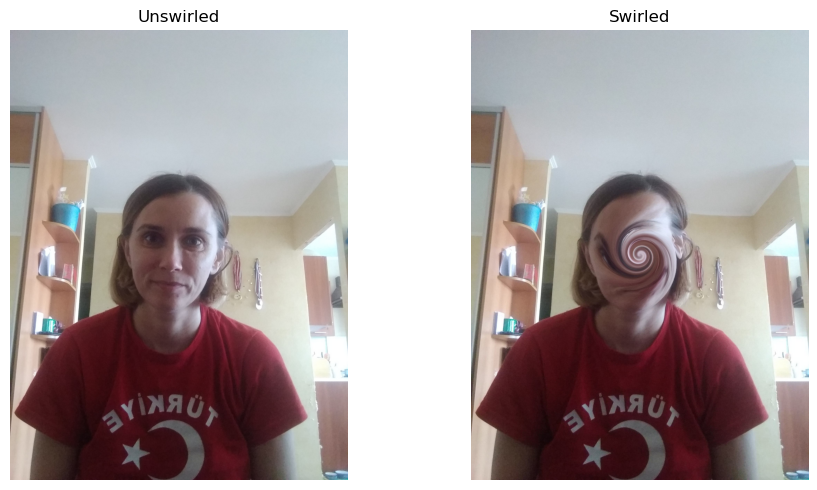

In [45]:
# Testing it has worked by displaying the first set of images from train
base_dir = 'UDA_FinalProject_Broomhead/Final_Project/images/train/'
unswirled_dir = os.path.join(base_dir, 'unswirled')
swirled_dir = os.path.join(base_dir, 'swirled')

valid_extensions = ('.jpg', '.jpeg')

#Sorting images
unswirled_images = [f for f in os.listdir(unswirled_dir) if f.lower().endswith(valid_extensions)]
swirled_images = [f for f in os.listdir(swirled_dir) if f.lower().endswith(valid_extensions)]

#Making sure they match
unswirled_images.sort()
swirled_images.sort()

#error/debug
if len(unswirled_images) != len(swirled_images):
    raise ValueError("Mismatch between the number of unswirled and swirled images.")

for unswirled, swirled in zip(unswirled_images, swirled_images):
    if unswirled != swirled:
        raise ValueError(f"Mismatched pair: {unswirled} and {swirled}")

#first image
unswirled_img_path = os.path.join(unswirled_dir, unswirled_images[0])
swirled_img_path = os.path.join(swirled_dir, swirled_images[0])

unswirled_img = Image.open(unswirled_img_path)
swirled_img = Image.open(swirled_img_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(unswirled_img)
axes[0].set_title('Unswirled')
axes[0].axis('off')

axes[1].imshow(swirled_img)
axes[1].set_title('Swirled')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Model architecture

In [13]:
#function for normalisation
def calculate_dataset_stats(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    channel_sum = torch.zeros(3)
    channel_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _, _ in loader:
        num_pixels += images.size(0) * images.size(2) * images.size(3)  #Batch sizexHeightxWidth
        channel_sum += images.sum(dim=[0, 2, 3])
        channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])

    mean = channel_sum / num_pixels
    std = torch.sqrt(channel_squared_sum / num_pixels - mean ** 2)
    return mean.tolist(), std.tolist()

In [31]:
#Creating a class for the swirl/ unswirl image pairs

class SwirlUnswirlDataset(Dataset):
    def __init__(self, root, transform=None, valid_extensions=('.jpg', '.jpeg')):
        self.root = root
        self.transform = transform

        self.swirled_dir = os.path.join(root, 'swirled')
        self.unswirled_dir = os.path.join(root, 'unswirled')

        #Getting files
        swirled_files = []
        for ext in valid_extensions:
            swirled_files.extend(glob(os.path.join(self.swirled_dir, f'*{ext}')))
        swirled_files = sorted(swirled_files)

        # Build data list
        self.data = []
        for idx, sf in enumerate(swirled_files):
            fname = os.path.basename(sf)
            uf = os.path.join(self.unswirled_dir, fname)
            if os.path.exists(uf):
                self.data.append((sf, uf, idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        swirled_path, unswirled_path, img_idx = self.data[idx]

        swirled_img = Image.open(swirled_path).convert('RGB')
        unswirled_img = Image.open(unswirled_path).convert('RGB')

        if self.transform:
            swirled_img = self.transform(swirled_img)
            unswirled_img = self.transform(unswirled_img)

        return swirled_img, unswirled_img, img_idx


In [15]:
##Warp function so that we can visualise model outputs using the predicted flow field from Unet

def warp_image(image, distortion_field):
    """
    Warps the input image using the predicted distortion field from our distortion field U net.

    Input:
        Tensor image: Input image of shape (B, C, H, W) - must be a tensor.
        distortion_field: Distortion field of shape (B, 2, H, W) - also a tensor.

    Ouptut:
        Warped image of shape (B, C, H, W) - tensor output.
    """
    B, C, H, W = image.size()
    dx, dy = distortion_field[:, 0, :, :], distortion_field[:, 1, :, :]

    #Mshgrid for tensor
    x, y = torch.meshgrid(torch.arange(0, W, device=image.device), torch.arange(0, H, device=image.device), indexing="xy")
    x = x.float().unsqueeze(0).expand(B, -1, -1)
    y = y.float().unsqueeze(0).expand(B, -1, -1)

    #Applying the flow field
    x_new = x + dx
    y_new = y + dy

    #Normalizing
    x_new = 2.0 * x_new / (W - 1) - 1.0
    y_new = 2.0 * y_new / (H - 1) - 1.0
    grid = torch.stack((x_new, y_new), dim=-1)

    #Returning normalised image
    warped_image = F.grid_sample(image, grid, mode='bilinear', align_corners=True)
    return warped_image


In [16]:
#Self attention layer

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  #Hyper Parameter

    def forward(self, x):
        B, C, H, W = x.size()

        # Query value and key
        query = self.query(x).view(B, -1, H * W)
        value = self.value(x).view(B, -1, H * W)
        key = self.key(x).view(B, -1, H * W)

        #Atention map
        attention = torch.bmm(query.permute(0, 2, 1), key)
        attention = F.softmax(attention, dim=-1)

        #applying attention map
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)

        #Scale and add residual for output
        out = self.gamma * out + x
        return out


In [17]:
#Distortion field U-net CNN

class DistortionFieldUNet(nn.Module):
    def __init__(self):
        super(DistortionFieldUNet, self).__init__()

        #Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        #Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        #Attention layers - 4 of them
        self.att4 = SelfAttention(512)
        self.att3 = SelfAttention(256)
        self.att2 = SelfAttention(128)
        self.att1 = SelfAttention(64)

        #Decoder
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)

        #Output
        self.output = nn.Conv2d(64, 2, kernel_size=1, stride=1, padding=0)  #2 channels (x, y) for displacement

    def conv_block(self, in_channels, out_channels):
        """
        Convolutional layer with Conv2D, BatchNorm, ReLU, and Dropout.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        #Decoder with self attention
        d4 = F.interpolate(b, scale_factor=2, mode='bilinear', align_corners=True)
        d4 = torch.cat((d4, self.att4(e4)), dim=1)
        d4 = self.dec4(d4)

        d3 = F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True)
        d3 = torch.cat((d3, self.att3(e3)), dim=1)
        d3 = self.dec3(d3)

        d2 = F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True)
        d2 = torch.cat((d2, self.att2(e2)), dim=1)
        d2 = self.dec2(d2)

        d1 = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True)
        d1 = torch.cat((d1, self.att1(e1)), dim=1)
        d1 = self.dec1(d1)

        #Output layer
        output = self.output(d1)  #Distortion field (x, y)
        return output


In [18]:
#Creating a mask for the swirl region so that loss is only calculated inside this mask
#This prevents the model from overfitting to the trivial unchanged solution
#and focusses the model on only the area inside the mask

max_radius = 500 #we know that is the max radius for our training dataset

def create_circular_mask(image_size, center, max_radius):
    """
    Creates a circular mask to focus the loss within a specified radius from the center of the image.

    Inputs:
        image_size (tuple): (Height, Width) of  image.
        center (tuple): (x, y) center of the swirl.
        max_radius (int): Maximum radius for the mask.

    Output:
        torch.Tensor: A binary circular mask of shape (Height, Width) with 1s inside the radius and 0s outside.
    """
    H, W = image_size
    y, x = torch.meshgrid(torch.arange(0, H), torch.arange(0, W), indexing="ij")
    y, x = y.to(torch.float32), x.to(torch.float32)

    #Area for the mask
    dist_sq = (x - center[0]) ** 2 + (y - center[1]) ** 2

    #Indicator function with 1 inside mask, 0 outside.
    mask = (dist_sq <= max_radius**2).float()
    return mask

In [19]:
#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Initialising pretrained perceptual loss
# Load VGG model
vgg = vgg16(pretrained=True).features[:16].eval().to(device)  # Use the first 16 layers for feature extraction

# Freeze VGG model parameters
for param in vgg.parameters():
    param.requires_grad = False


# Denormalization function
def denormalize(tensor, mean, std):
    """Undoes normalization for a tensor - for use in training."""
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(tensor.device)
    return tensor * std + mean


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s]


In [41]:

def train_unet_with_mask(
    train_loader,
    val_loader,
    model,
    optimizer,
    num_epochs=50,
    patience=5,
    mean=None,
    std=None
):
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided.")

    #Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=patience)

    #Early stopping
    early_stopping_patience = patience
    early_stopping_counter = 0
    best_val_loss = float("inf")

    #Mask at center of swirl
    H, W = 128, 128
    center = (W // 2, H // 2)
    max_radius = 500
    mask = create_circular_mask((H, W), center, max_radius).to(device)

    #Storing losses for visualisation
    train_losses = []
    val_losses = []
    learning_rates = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        #Training
        for batch_idx, (swirled, unswirled, _) in enumerate(train_loader):
            swirled, unswirled = swirled.to(device), unswirled.to(device)

            # Forward pass
            distortion_field = model(swirled)
            warped_images = warp_image(swirled, distortion_field)

            #Denormalization
            warped_images_dn = denormalize(warped_images * mask, mean=mean, std=std)
            unswirled_dn = denormalize(unswirled * mask, mean=mean, std=std)

            #Clamping
            warped_images_clamped = torch.clamp(warped_images_dn, 0, 1)
            unswirled_clamped = torch.clamp(unswirled_dn, 0, 1)

            #SSIM loss
            reconstruction_loss = 1 - ssim(warped_images_clamped, unswirled_clamped, data_range=1.0)

            #Smoothness loss
            smoothness_loss = torch.mean(torch.abs(distortion_field[:, :, :, :-1] - distortion_field[:, :, :, 1:])) + \
                              torch.mean(torch.abs(distortion_field[:, :, :-1, :] - distortion_field[:, :, 1:, :]))

            #Perceptual loss
            mse_loss = MSELoss()
            vgg_reconstructed = F.interpolate(warped_images_clamped, size=(224, 224), mode='bilinear', align_corners=False)
            vgg_unswirled = F.interpolate(unswirled_clamped, size=(224, 224), mode='bilinear', align_corners=False)
            perceptual_loss_value = mse_loss(vgg(vgg_reconstructed), vgg(vgg_unswirled))

            #Adding all three losses
            loss = reconstruction_loss + 0.001 * smoothness_loss + 0.01 * perceptual_loss_value

            #Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for swirled, unswirled, _ in val_loader:
                swirled, unswirled = swirled.to(device), unswirled.to(device)

                # Forward pass
                distortion_field = model(swirled)
                warped_images = warp_image(swirled, distortion_field)

                # Denormalize images
                warped_images_dn = denormalize(warped_images * mask, mean=mean, std=std)
                unswirled_dn = denormalize(unswirled * mask, mean=mean, std=std)

                # Clamp to [0, 1]
                warped_images_clamped = torch.clamp(warped_images_dn, 0, 1)
                unswirled_clamped = torch.clamp(unswirled_dn, 0, 1)

                # SSIM loss
                reconstruction_loss = 1 - ssim(warped_images_clamped, unswirled_clamped, data_range=1.0)

                # Smoothness loss
                smoothness_loss = torch.mean(torch.abs(distortion_field[:, :, :, :-1] - distortion_field[:, :, :, 1:])) + \
                                  torch.mean(torch.abs(distortion_field[:, :, :-1, :] - distortion_field[:, :, 1:, :]))

                # Perceptual loss
                vgg_reconstructed = F.interpolate(warped_images_clamped, size=(224, 224), mode='bilinear', align_corners=False)
                vgg_unswirled = F.interpolate(unswirled_clamped, size=(224, 224), mode='bilinear', align_corners=False)
                perceptual_loss_value = mse_loss(vgg(vgg_reconstructed), vgg(vgg_unswirled))

                # Total loss
                loss = reconstruction_loss + 0.001 * smoothness_loss + 0.01 * perceptual_loss_value
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Print current learning rate using get_last_lr()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Learning rate after epoch {epoch + 1}: {current_lr}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            print(f"Validation loss improved to {best_val_loss:.4f}, saving model.")
            torch.save(model.state_dict(), "best_model.pth")
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{early_stopping_patience}")

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered. Training terminated.")
            break

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        learning_rates.append(current_lr)

    print("Training complete!")

    return train_losses, val_losses, learning_rates  # Return the collected data



In [22]:
#function to visualise the results of the model
def visualize_results(loader, model):
    """
      Randomly selects a batch of images, applys our function
      and then visualises the two images plus the models predicted output

    Inputs:
        Loader: Dataloader containing images of the class SwirlUnswirlDataset

    Output:
        Three images: The two images in the loader plus the models predicted output
    """
    model.eval()
    with torch.no_grad():
        #Randomly select a batch index
        batch_index = random.randint(0, len(loader) - 1)

        #Get the selected batch from the loader
        batch = next(iter(loader))
        for i, current_batch in enumerate(loader):
            if i == batch_index:
                batch = current_batch
                break

        swirled, unswirled, _ = batch
        swirled, unswirled = swirled.to(device), unswirled.to(device)

        #Using distorition field from the model
        distortion_field = model(swirled)
        reconstructed = warp_image(swirled, distortion_field)

        #Unpacking images for visualisation
        swirled_np = swirled[0].cpu().permute(1, 2, 0).numpy()
        unswirled_np = unswirled[0].cpu().permute(1, 2, 0).numpy()
        reconstructed_np = reconstructed[0].cpu().permute(1, 2, 0).numpy()

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Swirled Image")
        plt.imshow(swirled_np)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Unswirled")
        plt.imshow(unswirled_np)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("UNet predicted Image")
        plt.imshow(reconstructed_np)
        plt.axis("off")

        plt.show()

## Training the model




In [33]:
#transform for initialisation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converting to tensor
])

Just going to test on a subset of 1000 images due to GPU contraints and time contraints. I picked the first 800 in the train folder to use, and then the next 100 for test and the next 100 for val, since the images are randomly assigned to train test and val loaders previously, it makes no difference what folder i select. 

In [50]:
#Roots
train_root = "UDA_FinalProject_Broomhead/Final_Project/images/train/"
val_root = "UDA_FinalProject_Broomhead/Final_Project/images/val/"
test_root = "UDA_FinalProject_Broomhead/Final_Project/images/test/"

#Initialise the correct class
train_dataset = SwirlUnswirlDataset(root=train_root, transform=transform)
val_dataset = SwirlUnswirlDataset(root=val_root, transform=transform)
test_dataset = SwirlUnswirlDataset(root=test_root, transform=transform)

#Loaders for the model 
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

#verifying size
print(f"No. of training samples: {len(train_dataset)}")
print(f"No. of validation samples: {len(val_dataset)}")
print(f"No. of test samples: {len(test_dataset)}")



No. of training samples: 800
No. of validation samples: 100
No. of test samples: 100


In [50]:
#mean and std for normalisaiton
mean, std = calculate_dataset_stats(train_subset)
print(f"Dataset Mean: {mean}, Std: {std}")

Dataset Mean: [0.5864734053611755, 0.5504027009010315, 0.5293028950691223], Std: [0.27876758575439453, 0.280579149723053, 0.28008097410202026]


In [35]:
#new transforms for reloading normalized images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  #Usung our calculated mean and std
])

In [36]:
model = DistortionFieldUNet().to(device)

#Optimizer - using Adam
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [42]:
#Training model
train_loss, val_loss, learning_rates = train_unet_with_mask(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    optimizer=optimizer,
    num_epochs=100, # set epochs here
    patience=10,  #set patience here
    mean=mean,
    std=std
)

Epoch 1/100, Train Loss: 12.9024
Epoch 1, Validation Loss: 0.0415
Learning rate after epoch 1: 0.01
Validation loss improved to 0.0415, saving model.
Epoch 2/100, Train Loss: 12.5262
Epoch 2, Validation Loss: 0.0438
Learning rate after epoch 2: 0.01
Validation loss did not improve. Early stopping counter: 1/10
Epoch 3/100, Train Loss: 12.3640
Epoch 3, Validation Loss: 0.0399
Learning rate after epoch 3: 0.01
Validation loss improved to 0.0399, saving model.
Epoch 4/100, Train Loss: 12.2932
Epoch 4, Validation Loss: 0.0406
Learning rate after epoch 4: 0.01
Validation loss did not improve. Early stopping counter: 1/10
Epoch 5/100, Train Loss: 12.2249
Epoch 5, Validation Loss: 0.0418
Learning rate after epoch 5: 0.01
Validation loss did not improve. Early stopping counter: 2/10
Epoch 6/100, Train Loss: 12.1798
Epoch 6, Validation Loss: 0.0399
Learning rate after epoch 6: 0.01
Validation loss did not improve. Early stopping counter: 3/10
Epoch 7/100, Train Loss: 12.1287
Epoch 7, Validation

## Exploring and visualising results from our model

In [43]:
def visualize_results(loader, model):
    model.eval()
    with torch.no_grad():
        #Randomly selecting a batch
        batch_index = random.randint(0, len(loader) - 1)

        #Structure
        batch = next(iter(loader))
        for i, current_batch in enumerate(loader):
            if i == batch_index:
                batch = current_batch
                break

        swirled, unswirled, _ = batch

        swirled, unswirled = swirled.to(device), unswirled.to(device)

        #Predicting distortion field  using Unet
        distortion_field = model(swirled)
        reconstructed = warp_image(swirled, distortion_field)

        #Graph
        swirled_np = swirled[0].cpu().permute(1, 2, 0).numpy()
        unswirled_np = unswirled[0].cpu().permute(1, 2, 0).numpy()
        reconstructed_np = reconstructed[0].cpu().permute(1, 2, 0).numpy()

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Swirled Image")
        plt.imshow(swirled_np)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Unswirled")
        plt.imshow(unswirled_np)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Reconstructed Image")
        plt.imshow(reconstructed_np)
        plt.axis("off")

        plt.show()

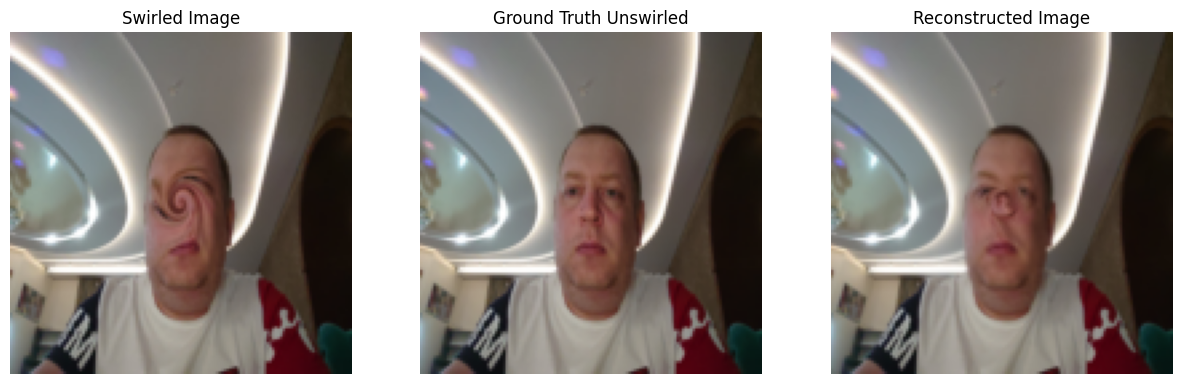

In [44]:
# Pass the first batch to visualize_results
visualize_results(test_loader, model)

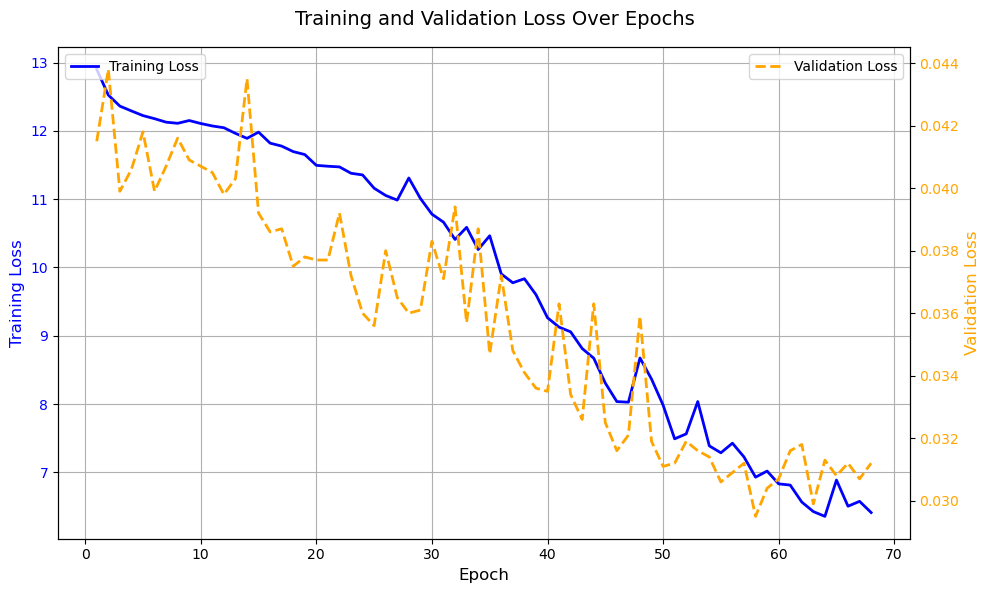

In [2]:
#Visualising train and val loss over epochs
epochs = list(range(1, len(train_loss) + 1))

fig, ax1 = plt.subplots(figsize=(10, 6))

#Train loss
ax1.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

#Val loss on second axis
ax2 = ax1.twinx()
ax2.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
ax2.set_ylabel('Validation Loss', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')


fig.suptitle('Training and Validation Loss Over Epochs', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [3]:
#Examining test loss 

# Calculate and print test loss
def evaluate_test_loss(test_loader, model, mean, std):
    model.eval() # set model to evaluation mode
    test_loss = 0
    H, W = 128, 128  
    center = (W // 2, H // 2)
    max_radius = 500
    mask = create_circular_mask((H, W), center, max_radius).to(device)

    with torch.no_grad():
        for swirled, unswirled, _ in test_loader:
            swirled, unswirled = swirled.to(device), unswirled.to(device)

            #Forward
            distortion_field = model(swirled)
            warped_images = warp_image(swirled, distortion_field)

            #Denorm
            warped_images_dn = denormalize(warped_images * mask, mean=mean, std=std)
            unswirled_dn = denormalize(unswirled * mask, mean=mean, std=std)

            #Clamp
            warped_images_clamped = torch.clamp(warped_images_dn, 0, 1)
            unswirled_clamped = torch.clamp(unswirled_dn, 0, 1)

            #SSIM
            reconstruction_loss = 1 - ssim(warped_images_clamped, unswirled_clamped, data_range=1.0)

            #Smoothness
            smoothness_loss = torch.mean(torch.abs(distortion_field[:, :, :, :-1] - distortion_field[:, :, :, 1:])) + \
                              torch.mean(torch.abs(distortion_field[:, :, :-1, :] - distortion_field[:, :, 1:, :]))

            #Perceptual
            vgg_reconstructed = F.interpolate(warped_images_clamped, size=(224, 224), mode='bilinear', align_corners=False)
            vgg_unswirled = F.interpolate(unswirled_clamped, size=(224, 224), mode='bilinear', align_corners=False)
            perceptual_loss_value = mse_loss(vgg(vgg_reconstructed), vgg(vgg_unswirled))

            #Total
            loss = reconstruction_loss + 0.001 * smoothness_loss + 0.01 * perceptual_loss_value
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

#Evaluating our test loss
evaluate_test_loss(test_loader=test_loader, model=model, mean=mean, std=std)

Test Loss: 0.0325
